In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
#Expects timeseries.py in same folder as nb. 
from fastai.text import *
from fastai.vision import *
from pathlib import Path
import pdb
import re
import seaborn as sns
from IPython.display import SVG, display
from wand.image import Image as WImage
import wand

In [3]:
path = Path("../google-fonts-subset")

In [4]:
out = []
for file in path.glob("**/*.svg"):
    try:
        match = re.match(".*viewBox=\"0 0 (\d+) (\d+)\".*<path.*d=\"([^\"]*)\".*",file.open().read(),flags=re.DOTALL)
        out.append({"file": file, "path": match.group(3), "box_x": float(match.group(1)), "box_y": float(match.group(2))})
    except:
        pass

In [5]:
svgDF = pd.DataFrame(out)
svgDF["png"] = svgDF.file.apply(lambda f: "/".join(f.parts[:-2]) + "/png/" + f.name[:-3] + "png")
svgDF.head()

,box_x,box_y,file,path,png
0,535.0,1000.0,../google-fonts-subset/italic/SANS_SERIF/asap/...,M32 34q0 10 1 16l2 17q3 27 11.5 38.5t24.5 11.5...,../google-fonts-subset/italic/SANS_SERIF/asap/...
1,843.0,1000.0,../google-fonts-subset/italic/SANS_SERIF/asap/...,M57 6.5q-13 8.5 -11 28.5l66 635q3 32 63 32h52q...,../google-fonts-subset/italic/SANS_SERIF/asap/...
2,489.0,1000.0,../google-fonts-subset/italic/SANS_SERIF/asap/...,M15.5 24.5q-8.5 24.5 -8.5 48.5q0 15 8 24l257 3...,../google-fonts-subset/italic/SANS_SERIF/asap/...
3,731.0,1000.0,../google-fonts-subset/italic/SANS_SERIF/asap/...,M493.5 -105.5q-133.5 56.5 -258.5 112.5q-97 44 ...,../google-fonts-subset/italic/SANS_SERIF/asap/...
4,549.0,1000.0,../google-fonts-subset/italic/SANS_SERIF/asap/...,M174 35l56 534h-158q-14 0 -20.5 9.5t-6.5 31.5q...,../google-fonts-subset/italic/SANS_SERIF/asap/...


In [6]:
def render_path(path,bbox_x,bbox_y):
    bbox_x,bbox_y = int(bbox_x),int(bbox_y)
    st = f'<svg viewBox="0 0 {bbox_x} {bbox_y}" xmlns="http://www.w3.org/2000/svg"><path d="{path}"/></svg>'
    img = WImage(blob=str.encode(st),format="svg",width=128,height=128)
    return img

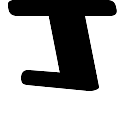

In [7]:
r = svgDF.iloc[0]
render_path(r.path,r.box_x,r.box_y)

In [9]:
tool_dict = {"P": 0, "M": 2, "m": 2, "L": 2, "l": 2, "H": 1, "h": 1, "V": 1, "v": 1, "C": 6, "c": 6, "S": 4, "s": 4, "Q": 4, "q": 4, "T": 2, "t": 2, "A": 7, "a": 7, "Z": 0, "z": 0}

class TokenizeSVGProcessor(PreProcessor):
    
    def tokenize(self,path,box_x,box_y):
        out = []
        for match in re.findall("([MmLlHhVvCcSsQqTtAaZz])([0-9\.\-\s]*)",path):
            token, pen = match
            xs = []
            for x in re.findall("((\-{0,1}\.[0-9]+)|(\-{0,1}[0-9]+\.{0,1}[0-9]*))\s*",pen):
                x = x[0]
                try:
                    xs.append(float(x)/box)
                except:
                    xs.append(0.0)
            td = tool_dict[token]
            assert td == 0 or (len(xs) % td == 0)
            if td == 0:
                out.append((token,[-2.0]*7))
            else:
                for i in range(0,len(xs),td):
                    s = xs[i:i+td]
                    if len(s) < 7: s += [-2.0] * (7-len(s))
                    out.append((token,s))
        return out
    
    def process(self, ds):
        ds.items = array([self.process_one(item) for item in ds.items])

    def process_one(self, item):
        return self.tokenize(*item)
    
class NumericalizeSVGProcessor(PreProcessor):
    def process_one(self,item):
        return [(self.stoi["START"],[-2.0]*7)] + [(self.stoi[t],n) for t,n in item] + [(self.stoi["END"],[-2.0]*7)]
            
    def process(self,ds):
        if not hasattr(self,"vocab"):
            vocab = ["PAD"] + list("MmLlHhVvCcSsQqTtAaZz") + ["START","END"]
            stoi = {s:i for i,s in enumerate(vocab)}
            self.vocab = ds.vocab = vocab
            self.stoi = ds.stoi = stoi
        super().process(ds)

In [10]:
class SVGList(ItemList):
    _processor = [TokenizeSVGProcessor,NumericalizeSVGProcessor]
    
    def get(self, i):
        item = self.items[i]
        return [t[0] for t in item], np.stack([t[1] for t in item])

In [11]:
def npad_collate(samples:BatchSamples, pad_idx:int=0) -> Tuple[LongTensor, LongTensor]:
    samples = to_data(samples)
    max_len = max([len(s[1][0]) for s in samples])
    res_tokens = torch.zeros(len(samples), max_len).long() + pad_idx
    res_numbers = torch.zeros(len(samples),max_len, 7) - 2.0
    for i,s in enumerate(samples):
        res_tokens[i,:len(s[1][0])] = LongTensor(s[1][0])
        res_numbers[i,:len(s[1][0])] = FloatTensor(s[1][1])
    return torch.stack([s[0] for s in samples]), (res_tokens,res_numbers)

In [12]:
bs = 2
data = (ImageList.from_df(svgDF,path="",cols="png")
        .split_none()
        .label_from_df(cols=["path","box_x","box_y"],label_cls=SVGList)
        .transform(size=64)
        .databunch(bs=bs,collate_fn=npad_collate))

In [13]:
#Dataloader is in data.train_dl. Return x,y pairs, where x is the png image and y is a tuple containing the numericalized token and continuous 
#variables

next(iter(data.train_dl))

[tensor([[[[0.2667, 0.2667, 0.2667,  ..., 0.2667, 0.2667, 0.2667],
           [0.2667, 0.2667, 0.2667,  ..., 0.2667, 0.2667, 0.2667],
           [0.2667, 0.2667, 0.2667,  ..., 0.2667, 0.2667, 0.2667],
           ...,
           [0.2667, 0.2667, 0.2667,  ..., 0.2667, 0.2667, 0.2667],
           [0.2667, 0.2667, 0.2667,  ..., 0.2667, 0.2667, 0.2667],
           [0.2667, 0.2667, 0.2667,  ..., 0.2667, 0.2667, 0.2667]],
 
          [[0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
           [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
           [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
           ...,
           [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
           [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
           [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039]],
 
          [[0.3294, 0.3294, 0.3294,  ..., 0.3294, 0.3294, 0.3294],
           [0.3294, 0.3294, 0.3294,  ..., 0.3294, 0.3294, 0.3294],
           [0.3294, 0.32